# XCROCO Example Notebook

## First, follow these steps to install the XCROCO package

- Type `which pip` in the terminal and make sure the returned location of the pip package manager is in your miniconda path. If this is not the case, activate your conda environment by typing `source /your-miniconda-path/bin/activate your-environment`. If pip is not part of your conda installation/environment yet, install it with `conda install pip`.
- Create and/or go to a folder of your choosing, for example `/Users/your-username/your-code-folder/`
- Clone the XCROCO repository with `git clone git://github.com/jaard/xcroco.git`. If you don't have SSH keys for github.com set up, try `git clone https://github.com/jaard/xcroco.git` and enter your github password. If you don't have git installed or all else fails, manually download an archive from `https://github.com/jaard/xcroco` and unpack into the desired folder.
- Manually install dependencies by `conda install xarray numpy scipy` and `conda install -c conda-forge xgcm` to avoid problems
- Finally, install XCROCO with `pip install -e /Users/your-username/your-code-folder/xcroco`

In [1]:
import xcroco as xco
import xarray as xr
import xgcm as xg
import numpy as np
import matplotlib.pyplot as plt
import glob
import time

In [3]:
def update_progress(progress):
    bar_length = 40
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    sys.stdout.write("\r" + str(text))
    sys.stdout.flush()
    
class Stopwatch():
    def __init__(self):
        pass
    def tic(self):
        self.starttime = time.time()
    def toc(self):
        self.stoptime = time.time()-self.starttime
        if self.stoptime < 60:
            print('Elapsed time is {0:.2f} seconds.'.format(self.stoptime))
        elif self.stoptime < 3600:
            print('Elapsed time is {0:.2f} minutes.'.format(self.stoptime/60))
        else:
            print('Elapsed time is {0:.2f} hours.'.format(self.stoptime/3600))
            
watch = Stopwatch()

## Load some CROCO output (series of files)

Choose some CROCO output file(s) on your local disk

In [4]:
model_path_jaard = glob.glob('/Users/jhauschildt/Documents/PhD/data/roms/int9c0c/avg/roms10_avg.Y2017.M*.int9c0c.nc')
output_jaard = xr.open_mfdataset(model_path_jaard, combine='by_coords')

#grid_path = '/Users/jhauschildt/Documents/PhD/data/roms/int9c0c/grid/roms10_dist2coast_grd.nc'

In [5]:
#D = xco.croco_dataset(model_path, grid=grid_path)
D = xco.croco_dataset(model_path_jaard)

In [6]:
D['coastline_rho'] = xco.get_coastline_from_mask(D)

Calculating distances to 299 coastal points...
[########################################] 100.0%



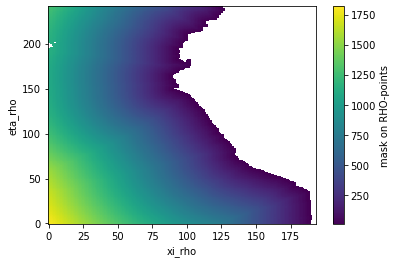

In [7]:
D['dist2coast'] = xco.distance2coast(D, condition=(D.lon_rho>-84)).where(D.mask_rho)
D['dist2coast'].plot()

## Compute the depth levels

In [8]:
# Depth at RHO points
z = D.z_rho.compute()
# z = D.z_rho <-- if you only read in one output file, leave off the ".compute()" of any command
display(z.attrs)

# Depth at RHO points
z = D.z_w.compute()
display(z.attrs)

# Depth at U points
z = D.z_u.compute()
display(z.attrs)

# Depth at V points
z = D.z_v.compute()
display(z.attrs)

{'long_name': 'depth at RHO-points',
 'units': 'meter',
 'field': 'depth, scalar, series',
 'standard_name': 'depth'}

{'long_name': 'depth at W-points',
 'units': 'meter',
 'field': 'depth, scalar, series',
 'standard_name': 'depth'}

{'long_name': 'depth at U-points',
 'units': 'meter',
 'field': 'depth, scalar, series',
 'standard_name': 'depth'}

{'long_name': 'depth at V-points',
 'units': 'meter',
 'field': 'depth, scalar, series',
 'standard_name': 'depth'}

## Extract and plot horizontal slices

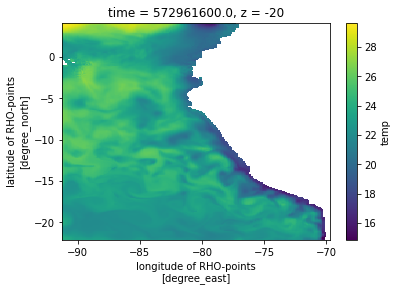

In [9]:
xco.hslice(D, D.temp, -20, masked=True).isel(time=0).plot(y='lat_rho',x='lon_rho')

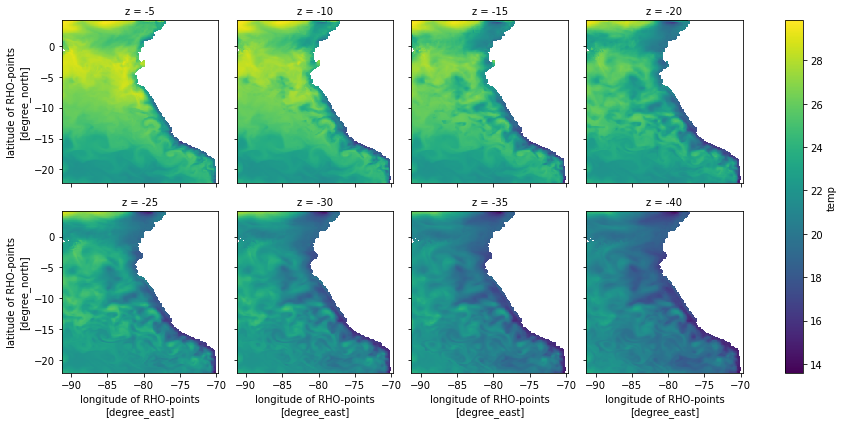

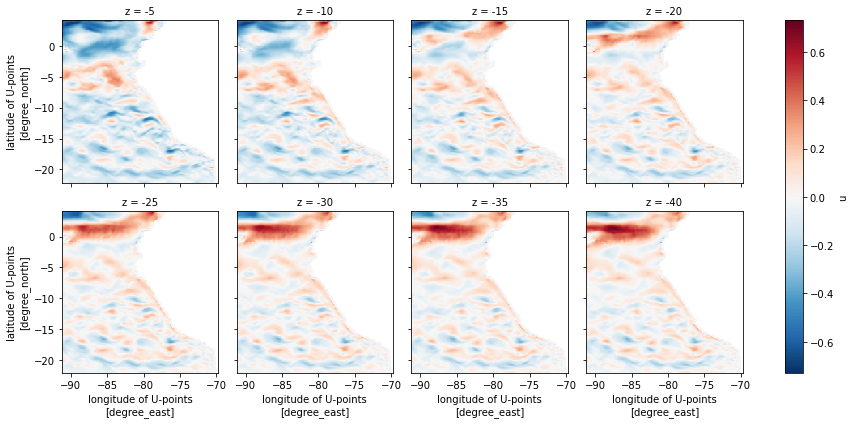

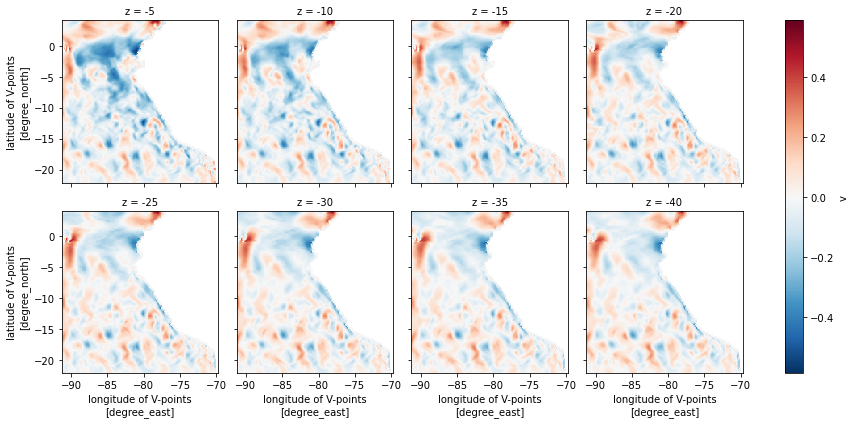

In [10]:
zlevs=np.arange(-5,-45,-5)
xco.hslice(D, D.temp, zlevs, masked=True).isel(time=0).plot(y='lat_rho',x='lon_rho', col='z', col_wrap=4)
xco.hslice(D, D.u, zlevs, masked=True).isel(time=0).plot(y='lat_u',x='lon_u', col='z', col_wrap=4)
xco.hslice(D, D.v, zlevs, masked=True).isel(time=0).plot(y='lat_v',x='lon_v', col='z', col_wrap=4)

## Extract and plot section with and without vertical interpolation

In [11]:
Npoints = 200
lat_ends = [-10,-15]
lon_ends = [-77,-84]
lats = np.linspace(lat_ends[0], lat_ends[1], Npoints)
lons = np.linspace(lon_ends[0], lon_ends[1], Npoints)
sec = xr.Dataset()
sec['salt'] = xco.vslice(D, D.salt, lat_rho=lats, lon_rho=lons).compute().load()
sec['salt_interp'] = xco.vslice(D, D.salt, lat_rho=lats, lon_rho=lons, zlevels=np.arange(-1000,0.1)).compute().load()
sec

<xarray.Dataset>
Dimensions:      (distance: 200, s_rho: 32, time: 20, z: 1001)
Coordinates:
    xi_rho       (distance) float64 128.0 127.7 127.4 127.1 ... 65.63 65.32 65.0
    eta_rho      (distance) float64 113.7 113.5 113.2 ... 68.05 67.82 67.58
  * s_rho        (s_rho) float32 -0.9844 -0.9531 -0.9219 ... -0.04688 -0.01562
  * time         (time) float64 5.73e+08 5.732e+08 ... 5.776e+08 5.779e+08
    z_rho        (s_rho, time, distance) float64 -18.95 -18.95 ... -2.276 -2.273
    lat_rho      (distance) float64 -10.0 -10.03 -10.05 ... -14.95 -14.97 -15.0
    lon_rho      (distance) float64 -77.0 -77.04 -77.07 ... -83.93 -83.96 -84.0
  * distance     (distance) float64 0.0 4.756 9.511 14.27 ... 931.5 936.2 940.9
  * z            (z) float64 -1e+03 -999.0 -998.0 -997.0 ... -3.0 -2.0 -1.0 0.0
Data variables:
    salt         (time, s_rho, distance) float64 nan nan nan ... 35.59 35.58
    salt_interp  (time, distance, z) float64 nan nan nan nan ... nan nan nan

(-1000.0, 0.0)

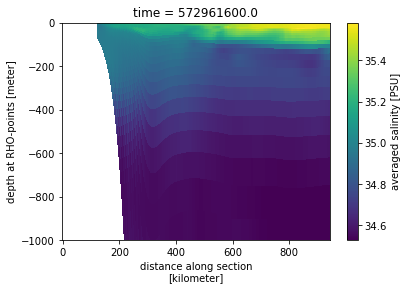

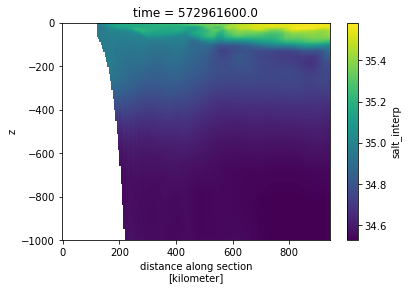

In [12]:
plt.figure()
sec.salt.isel(time=0).plot(y='z_rho')
plt.ylim([-1000, 0])

plt.figure()
sec.salt_interp.isel(time=0).plot(y='z')
plt.ylim([-1000, 0])

## Make Hovmoeller plot of a station without interpolating to Z-levels

In [13]:
surftemp = xco.hslice(D, D.temp, -31,masked=True).isel(time=0).compute().load()

lat = [-15]
lon = [-84]
sta = xr.Dataset()
sta['temp'] = xco.vslice(D, D.temp, lat_rho=lat, lon_rho=lon).compute().load()
sta['salt'] = xco.vslice(D, D.salt, lat_rho=lat, lon_rho=lon).compute().load()
sta

<xarray.Dataset>
Dimensions:  (s_rho: 32, time: 20)
Coordinates:
    xi_rho   float64 65.0
    eta_rho  float64 67.58
  * s_rho    (s_rho) float32 -0.9844 -0.9531 -0.9219 ... -0.04688 -0.01562
  * time     (time) float64 5.73e+08 5.732e+08 5.735e+08 ... 5.776e+08 5.779e+08
    z_rho    (s_rho, time) float64 -4.363e+03 -4.363e+03 ... -2.273 -2.273
    lat_rho  int64 -15
    lon_rho  int64 -84
Data variables:
    temp     (time, s_rho) float64 1.259 1.483 1.663 1.873 ... 23.6 23.58 23.56
    salt     (time, s_rho) float64 34.7 34.69 34.68 34.66 ... 35.58 35.58 35.58

(-1000.0, 0.0)

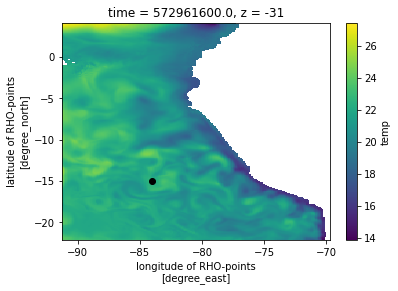

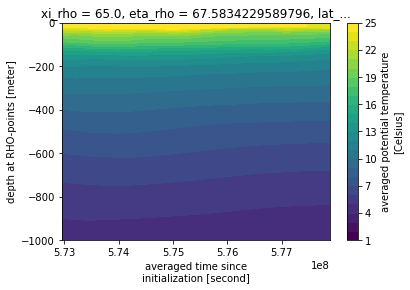

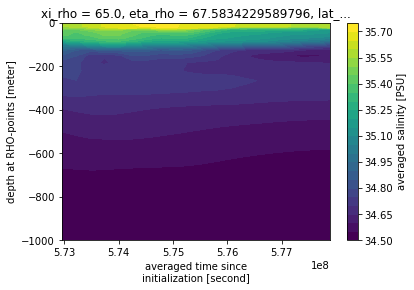

In [14]:
plt.figure()
surftemp.plot(x='lon_rho', y='lat_rho')
plt.plot(sta.lon_rho, sta.lat_rho, marker='o', color='k')

plt.figure()
sta.temp.plot.contourf(y='z_rho', x='time', levels=30)
plt.ylim([-1000, 0])
plt.figure()
sta.salt.plot.contourf(y='z_rho', x='time', levels=30)
plt.ylim([-1000, 0])

## Extract section and interpolate to Z-levels, make Hovmoeller plots

In [15]:
surftemp = xco.hslice(D, D.temp, -5, masked=True).isel(time=0).compute().load()

Npoints = 100
lat_ends = [-15,-15]
lon_ends = [-75,-84]
new_zlevels = np.arange(-500,1)
lats = np.linspace(lat_ends[0], lat_ends[1], Npoints)
lons = np.linspace(lon_ends[0], lon_ends[1], Npoints)
sec = xr.Dataset()
sec['temp'] = xco.vslice(D, D.temp, lat_rho=lats, lon_rho=lons).compute().load()
sec['salt'] = xco.vslice(D, D.salt, lat_rho=lats, lon_rho=lons).compute().load()
sec['O2'] = xco.vslice(D, D.O2, lat_rho=lats, lon_rho=lons).compute().load()
#sec
sec_zgrid = xr.Dataset()
new_zlevels = np.arange(-500,1)
sec.attrs['xgrid'] = xg.Grid(sec['temp'], periodic=False)
sec_zgrid['temp'] = xco.hslice(sec, sec['temp'], new_zlevels, masked=True)
sec_zgrid['salt'] = xco.hslice(sec, sec['salt'], new_zlevels, masked=True)
sec_zgrid['O2'] = xco.vslice(D, D.O2, lat_rho=lats, lon_rho=lons, zlevels=new_zlevels).compute().load()
sec_zgrid

<xarray.Dataset>
Dimensions:   (distance: 100, time: 20, z: 501)
Coordinates:
    xi_rho    (distance) float64 146.0 145.2 144.4 143.5 ... 66.64 65.82 65.0
    eta_rho   (distance) float64 67.58 67.58 67.58 67.58 ... 67.58 67.58 67.58
  * time      (time) float64 5.73e+08 5.732e+08 ... 5.776e+08 5.779e+08
    lat_rho   (distance) float64 -15.0 -15.0 -15.0 -15.0 ... -15.0 -15.0 -15.0
    lon_rho   (distance) float64 -75.0 -75.09 -75.18 ... -83.82 -83.91 -84.0
  * distance  (distance) float64 0.0 9.758 19.52 29.28 ... 946.6 956.4 966.1
  * z         (z) int64 -500 -499 -498 -497 -496 -495 -494 ... -5 -4 -3 -2 -1 0
Data variables:
    temp      (time, distance, z) float64 nan nan nan nan ... 23.57 nan nan nan
    salt      (time, distance, z) float64 nan nan nan nan ... 35.58 nan nan nan
    O2        (time, distance, z) float64 nan nan nan nan ... 223.0 nan nan nan

(966.1142618015291, 0.0)

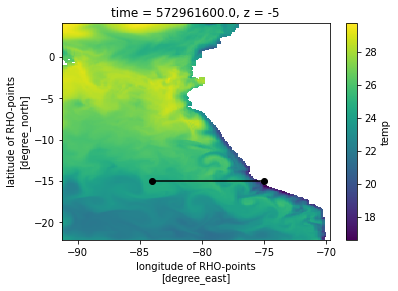

<Figure size 432x288 with 0 Axes>

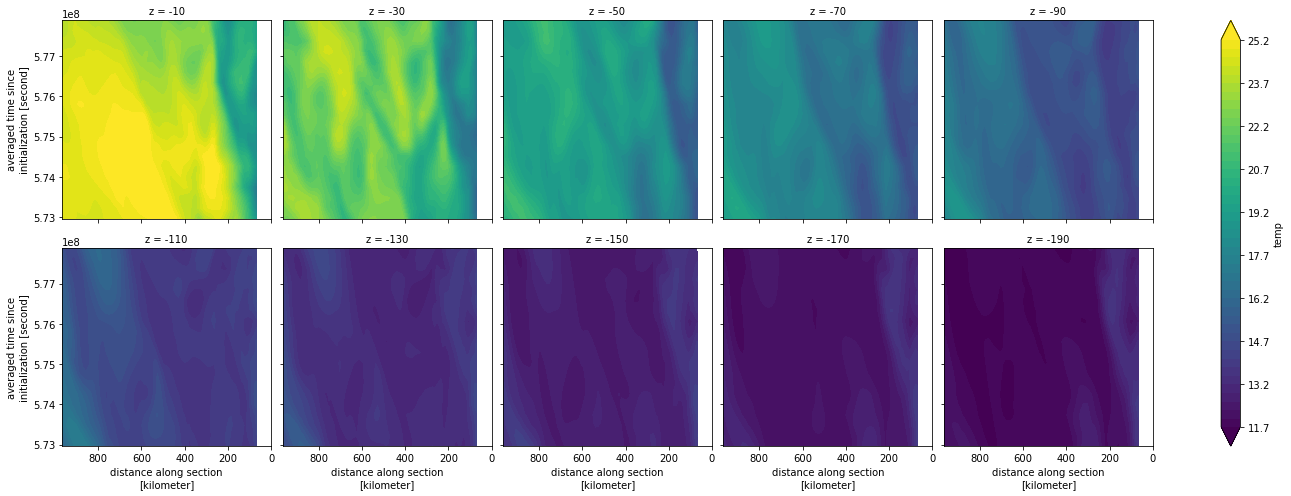

<Figure size 432x288 with 0 Axes>

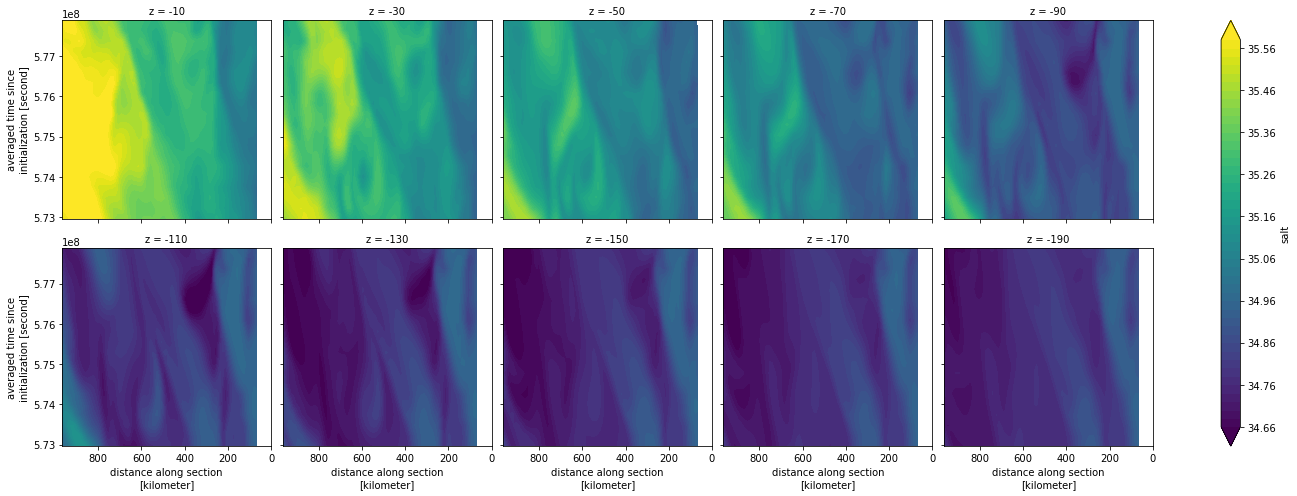

<Figure size 432x288 with 0 Axes>

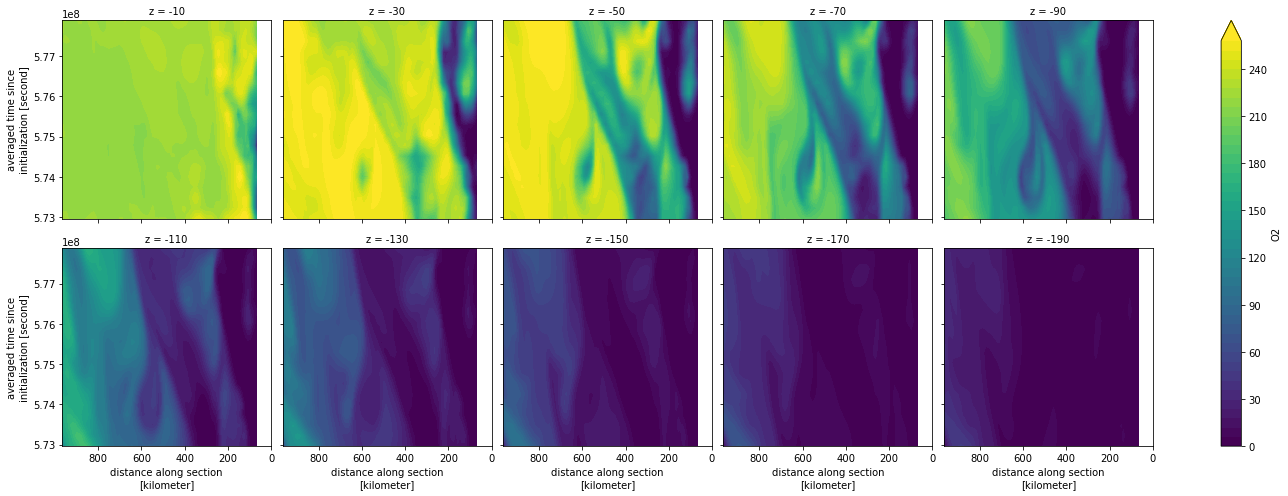

In [16]:
plt.figure()
surftemp.plot(x='lon_rho', y='lat_rho')
plt.plot(sec_zgrid.lon_rho[[0,-1]], sec_zgrid.lat_rho[[0,-1]], marker='o', color='k')

zplot=np.arange(10,210,20)*-1
fs = (20,7)
plt.figure()
sec_zgrid.temp.sel(z=zplot).plot.contourf(x='distance',levels=50, col='z', col_wrap=5, figsize=fs, robust=True)
plt.xlim([sec_zgrid.distance.max(), sec_zgrid.distance.min()])
plt.figure()
sec_zgrid.salt.sel(z=zplot).plot.contourf(x='distance',levels=50, col='z', col_wrap=5, figsize=fs, robust=True)
plt.xlim([sec_zgrid.distance.max(), sec_zgrid.distance.min()])
plt.figure()
sec_zgrid.O2.sel(z=zplot).plot.contourf(x='distance',levels=50, col='z', col_wrap=5, figsize=fs, robust=True)
plt.xlim([sec_zgrid.distance.max(), sec_zgrid.distance.min()])



## And finally an along-shore section...

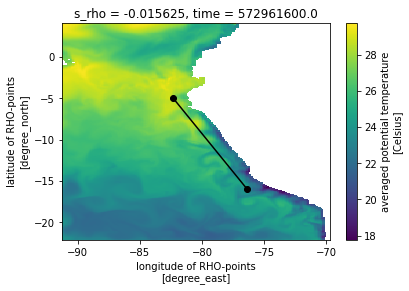

In [17]:
surftemp = D.temp.isel(time=0).isel(s_rho=-1).where(D.mask_rho).compute().load()

Npoints = 100
lat_ends = [-16,-5]
lon_ends = [-76.35,-82.3]
lats = np.linspace(lat_ends[0], lat_ends[1], Npoints)
lons = np.linspace(lon_ends[0], lon_ends[1], Npoints)
new_zlevels = list(np.arange(-500,0.1))
sec = xr.Dataset()
sec['temp'] = xco.vslice(D, D.temp, lat_rho=lats, lon_rho=lons, zlevels=new_zlevels).compute().load()
sec['salt'] = xco.vslice(D, D.salt, lat_rho=lats, lon_rho=lons, zlevels=new_zlevels).compute().load()
sec['O2'] = xco.vslice(D, D.O2, lat_rho=lats, lon_rho=lons, zlevels=new_zlevels).compute().load()
sec
#sec_zgrid = xr.Dataset()
#sec_zgrid['temp'] = xco.vinterp(sec.temp, sec.z_rho, new_zlevels)
#sec_zgrid['salt'] = xco.vinterp(sec.salt, sec.z_rho, new_zlevels)
#sec_zgrid['O2'] = xco.vinterp(sec.O2, sec.z_rho, new_zlevels)
#display(sec_zgrid)

plt.figure()
surftemp.plot(x='lon_rho', y='lat_rho')
plt.plot(sec.lon_rho[[0,-1]], sec.lat_rho[[0,-1]], marker='o', color='k')

<Figure size 432x288 with 0 Axes>

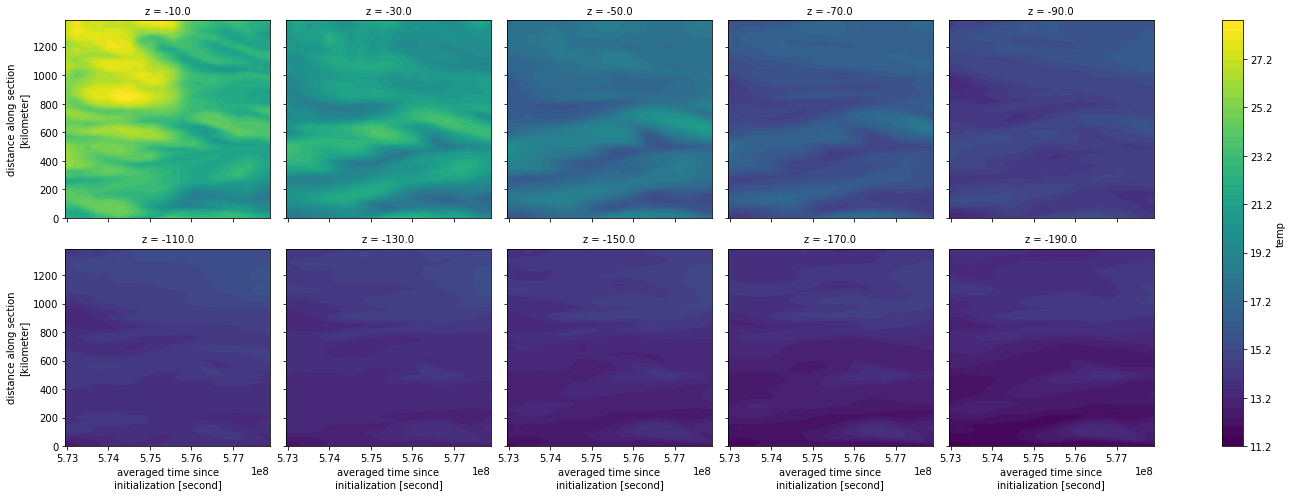

<Figure size 432x288 with 0 Axes>

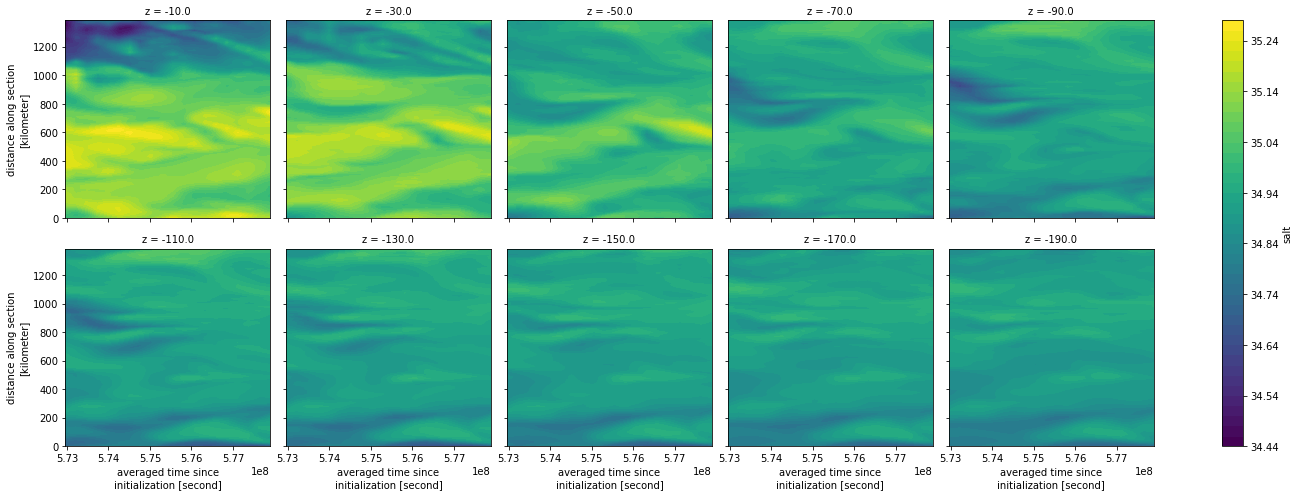

<Figure size 432x288 with 0 Axes>

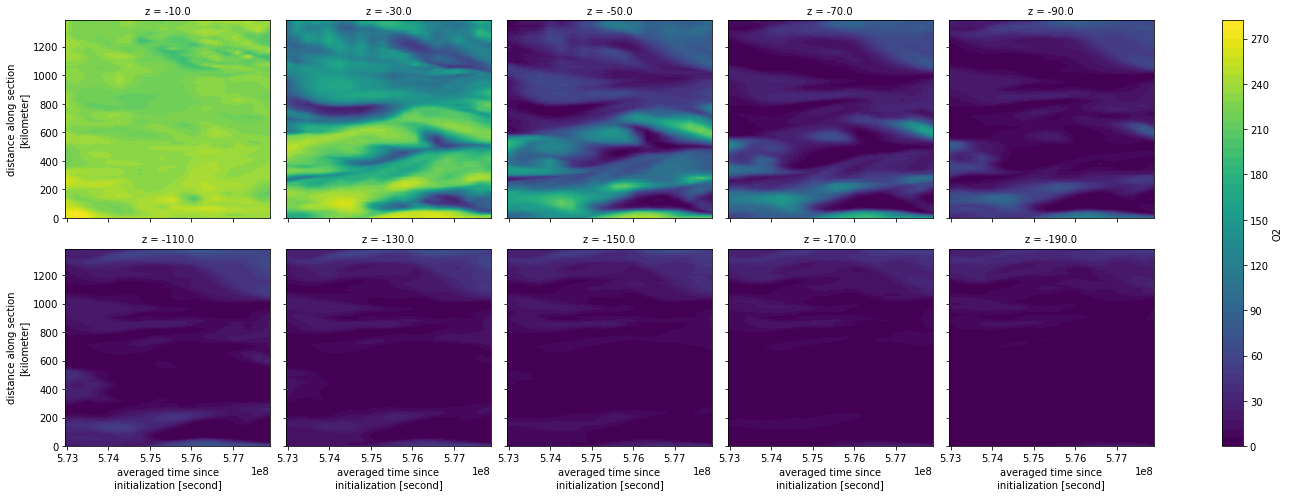

In [18]:
zplot=np.arange(10,210,20)*-1
fs = (20,7)
plt.figure()
sec.temp.sel(z=zplot).plot.contourf(y='distance',levels=50, col='z', col_wrap=5, figsize=fs)
plt.figure()
sec.salt.sel(z=zplot).plot.contourf(y='distance',levels=50, col='z', col_wrap=5, figsize=fs)
plt.figure()
sec.O2.sel(z=zplot).plot.contourf(y='distance',levels=50, col='z', col_wrap=5, figsize=fs)